<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/4_%ED%9A%8C%EA%B7%80%EC%99%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [1]:
! pip install wquantiles 
! pip install pygam
! pip install dmba

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.8 MB 8.8 MB/s 
     |████████████████████████████████| 11.8 MB 14.4 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend
Cloning into 'practical-statistics-for-data-scientists'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 368 (delta 78), reused 92 (delta 27), pack-reused 207
Receiving objects: 100% (368/368), 84.09 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (164/164), done.


# 1. 단순선형회귀

- 단순선형회귀 : X가 얼만큼 변하면 Y가 어느정도 변화하는지 추정 가능한 직선을 찾음

 $Y = b_0 + b_1X$
 - $b_1$ : 기울기

- 잔차(residual) : 관측값과 적합값(=예측값)의 차이

 $\hat{e}_i = Y_i - \hat{Y}_i$

- 최소제곱(least square) : 잔차의 제곱합을 최소화하여 회귀를 피팅하는 방법

 $RSS = \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 = \sum_{i=1}^{n}(Y_i - \hat{b_0}- \hat{b_1}X_i)^2 $
 - $ \hat{b_0}$ & $\hat{b_1}$ : RSS를 최소화 하는 값
 - RSS는 특잇값에 매우 민감

1. 면진에 대한 노출 연수와 폐활양 산점도


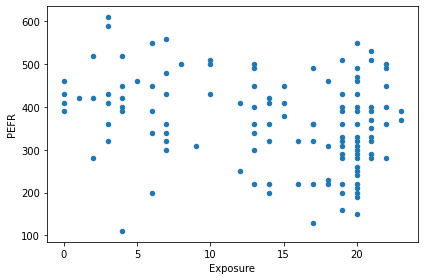

In [4]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
print('1. 면진에 대한 노출 연수와 폐활양 산점도')
plt.show()

In [6]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept(절편): {model.intercept_:.3f}')
print(f'Coefficient Exposure(계수): {model.coef_[0]:.3f}')

Intercept(절편): 424.583
Coefficient Exposure(계수): -4.185


2. 폐활량 회귀 적합도의 기울기 및 절편


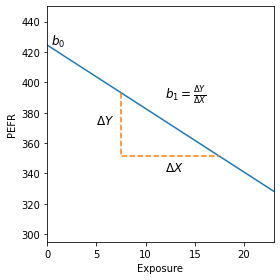

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
print("2. 폐활량 회귀 적합도의 기울기 및 절편")
plt.show()

3. 회귀선에 대한 잔차


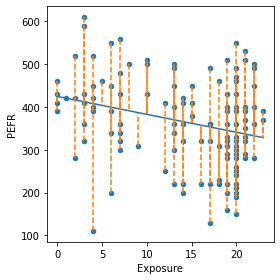

In [8]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
print("3. 회귀선에 대한 잔차")
plt.show()

# 2. 다중선형회귀

- 다중선형회귀 : 예측값이 여러개인 경우

  $Y = b_0 + b_1X_1 + b_2X_2 \cdots b_pX_p + e$

- 제곱근 평균제곱오차=RMSE(root mean squared error) : 회귀 시 평균제곱오차의 제곱근. 회귀모형을 평가하는 데 가장 널리 사용되는 측정 지표

 ## $RMSE = \frac{ \sqrt{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}  }{n}$ = 평균제곱오차의 제곱근

- 잔차 표준오차=RSE(residual standard error) : 평균제곱오차와 동일하지만 자유도에 따라 보정된 값

 ## $RSE = \frac{ \sqrt{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}  }{n-p-1}$
 - $p$ : 예측변수의 갯수

- R 제곱=$R^2$=결정계수(r-squared) : 0~1까지 모델에 의해 설명된 분산의 비율

 ## $ R^2 = 1 - \frac{ \sum_{i=1}^{n}(y_i - \hat{y_i})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2} $
 - $\bar{y}$ : 평균값

- 수정 R 제곱 : R제곱에서 모델 복잡성을 고려하는 방법

 ## $R^{2}_{adj} = 1-(1-R^2)\frac{n-1}{n-P-1}$
 - $n$ : 레코드 수, $p$ : 모델의 변수 갯수

- t 통계량(t-statistic): 계수의 표준오차로 나눈 예측변수의 계수. 모델에서 변수의 중요도를 비교하는 기준이 됨

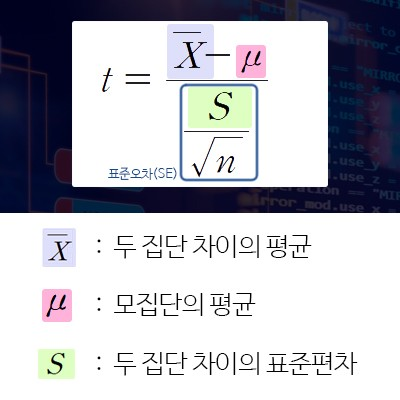

In [10]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print('1. 킹 카운티(워싱턴 시애틀)의 주택 가격 일부분')
print(house[subset].head())

1. 킹 카운티(워싱턴 시애틀)의 주택 가격 일부분
   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [23]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print('# 변수: 5개')
print(f'Intercept(절편): {house_lm.intercept_:.3f}')
print('Coefficients(변수별 계수):')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

# 변수: 5개
Intercept(절편): -521871.368
Coefficients(변수별 계수):
 SqFtTotLiving: 228.83060360240796
 SqFtLot: -0.06046682065307607
 Bathrooms: -19442.840398321056
 Bedrooms: -47769.95518521438
 BldgGrade: 106106.96307898083


In [24]:
fitted = house_lm.predict(house[predictors])

num_data = house[predictors].shape[0]

MSE = mean_squared_error(house[outcome], fitted)
RMSE = np.sqrt(MSE)
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [25]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1)) # 상수 열을 예측 변수에 추가 (모델링 위해)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:24:21   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

- t가 높(=p가 낮)을 수록 예측 변수가 더욱 유의미

In [26]:
print('# 변수: 11개')
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

# 변수: 11개
                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:24:48   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiv

In [28]:
print('# 부분집합회귀 구현')
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

# 부분집합회귀 구현
Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201884
 BldgGrade: 137159.56022619773
 YrBuilt: -3565.4249392492993
 Bedrooms: -51947.38367361318
 Bathrooms: 42396.164527717796
 PropertyType_Townhouse: 84479.16203300405
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.055187017682


- 단계적 회귀를 통해 삭제된 변수 : 'SqFtLot', 'NbrLivingUnits', 'YrRenovated', 'NewConstruction'
- 부분집합회귀(=단계적 회귀) : 모델을 만드는 데 필요한 변수들을 자동으로 결정하는 방법


In [36]:
print('# 가중회귀 구현(변수 5개 기준)')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
# 가중치 고려
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight) 
pd.DataFrame({
    'predictor': predictors,
    'house_lm(기존)': house_lm.coef_,
    'house_wt(가중치)': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm(기존)': house_lm.intercept_,
    'house_wt(가중치)': house_wt.intercept_,
}, ignore_index=True)


# 가중회귀 구현(변수 5개 기준)


,predictor,house_lm(기존),house_wt(가중치)
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
5,intercept,-521871.368188,-584189.329446


- 가중회귀 : 방정식을 피팅할 때 레코드별로 가중치를 주기 위해 사용

# 3. 회귀를 이용한 예측

- 데이터 범위를 벗어나는 외삽은 오류를 유발
- 신뢰구간은 회귀계수 주변의 불확실성을 정량화
- 예측구간은 개별 예측값의 불확실성을 정량화
- R을 포함한 대부분의 소프트웨어는 수식을 사용하여 예측/신뢰구간을 기본 또는 지정된 출력으로 생성
- 수식 대신 부트스트랩을 사용할 수도 있다. 해석과 개념은 같다.



# 4. 회귀에서의 요인변수

- 요인변수(범주형 변수)는 회귀를 위해 수치형 변수인 가변수로 변환 필요

- ex. 주택가격 데이터의 주거 형태

In [41]:
print('# PropertyType 값')
print(house.PropertyType.head())
print()
print('# 원핫인코딩(=가변수로 변환)')
print(pd.get_dummies(house['PropertyType']).head(6))
print()
print('# 원핫인코딩_P-1') # 다중공선성 문제 피하기 위해
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

# PropertyType 값
1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

# 원핫인코딩(=가변수로 변환)
   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1

# 원핫인코딩_P-1
   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [47]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True) # drop_first = P-1

print('# 주거형태_가변수화 데이터셋')
display(X)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print('# 예측 결과')
print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

# 주거형태_가변수화 데이터셋


,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,0,0
2,3764,20156,3.75,4,10,1,0
3,2060,26036,1.75,4,8,1,0
4,3200,8618,3.75,5,7,1,0
5,1720,8620,1.75,4,7,1,0
...,...,...,...,...,...,...,...
27057,1480,5468,1.75,3,7,1,0
27058,4720,23914,4.50,4,11,1,0
27061,1070,11170,1.00,4,6,1,0
27062,1345,6223,2.00,3,7,1,0


# 예측 결과
Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503822
 SqFtLot: -0.0703679813681255
 Bathrooms: -15979.013473415183
 Bedrooms: -50889.73218483028
 BldgGrade: 109416.3051614618
 PropertyType_Single Family: -84678.21629549256
 PropertyType_Townhouse: -115121.97921609186


- PropertyType_Single Family: -84678.21629549256
- PropertyType_Townhouse: -115121.97921609186
- 위의 2개 값들은 Multiplex에 대한 상대적인 값

 →결과적으로 Single Family 8만5천불, Townhouse는 15만불정도 Multiplex보다 가치가 낮다

In [48]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  ...  98288  98224  98043  98068  98113
ZipCode    788    671    641    620    619  ...      4      3      1      1      1

[1 rows x 80 columns]


In [53]:
print('# 요인변수(ZipGroup) 생성 : 80개의 우편번호를 5개의 그룹으로 통합')
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')
display(house)

# 요인변수(ZipGroup) 생성 : 80개의 우편번호를 5개의 그룹으로 통합
0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,2400,0,3.00,6,7,1991,0,0,70000,229000,98002,False,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,3764,1452,3.75,4,10,2005,0,0,203000,590000,98166,True,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,2060,900,1.75,4,8,1947,0,0,183000,275000,98166,False,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,3200,1640,3.75,5,7,1966,0,0,104000,229000,98168,False,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,1720,0,1.75,4,7,1948,0,0,104000,205000,98168,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,2011-04-08,325000,9842300710,Single Family,2011-04-01,318700,0.732307,443803.0,1,5468,1480,590,1.75,3,7,1951,0,0,201000,172000,98126,False,3
27058,2007-09-28,1580000,9845500010,Single Family,2007-09-01,433500,0.996094,1586196.0,1,23914,4720,910,4.50,4,11,2000,0,1,703000,951000,98040,False,4
27061,2012-07-09,165000,9899200010,Single Family,2012-07-01,325300,0.747472,220744.0,1,11170,1070,0,1.00,4,6,1971,0,0,92000,130000,98055,False,0
27062,2006-05-26,315000,9900000355,Single Family,2006-05-01,400600,0.920496,342207.0,1,6223,1345,0,2.00,3,7,1939,0,0,103000,212000,98166,False,2


# 5. 회귀방정식 해석

##### 1. 예측변수 간 상관

- 변수 간 상관(correlated variables): 예측변수들끼리 서로 높은 상관성을 갖을 때, 개별 계수를 해석하는 것은 어려움

In [58]:
print('# 부분 회귀모형의 회귀계수 검토')
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

# 부분 회귀모형의 회귀계수 검토
Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201884
 BldgGrade: 137159.56022619773
 YrBuilt: -3565.4249392492993
 Bedrooms: -51947.38367361318
 Bathrooms: 42396.164527717796
 PropertyType_Townhouse: 84479.16203300405
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.055187017682


- 침실 개수(Bedrooms)의 계수가 음수 → 침실 개수를 늘릴수록 가치가 감소 ?? → ** 예측변수들이 서로 연관되어 있기 때문 **

- 집이 크다 → 침실 많다 → 침실 수보다는 주택의 크기가 주택 가격에 큰 영향 → 똑같은 크기의 집이라면 작은 크기의 침실이 여러개 있는것을 선호 하지 X


In [59]:
print('# 상관 변수들(SqFtTotLiving, Bathrooms, SqFtFinBasement) 제거')

redictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

# 연관된 변수들(SqFtTotLiving, Bathrooms, SqFtFinBasement) 제거
Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215377
 BldgGrade: 248997.79366213758
 YrBuilt: -3211.7448621550866
 PropertyType_Single Family: -19898.495340502435
 PropertyType_Townhouse: -47355.4368733449


- 이제 Bedrooms이 기대한 바와 같이 양수인 것을 확인할 수 있다.

##### 2. 다중공선성(multicollineartiy)

- 다중공선성(multicollineartiy) : 예측변수들이 완벽하거나 거의 완벽에 가까운 상관성을 갖는다고 할 때, 회귀는 불안정하며 계산이 불가능하다. (유의어 : 공선성(collinearity))

 - 다중공선성 발생 이유
 1. 오류로 인해 한 변수가 여러 번 포함된 경우
 2. 요인변수로부터 p-1개가 아닌 p개의 가변수가 만들어진 경우
 3. 두 변수가 서로 거의 완벽하게 상관성이 있는 경우

 → but 요즘 S/W 들은 다중공선성 문제를 자동으로 처리함

##### 3. 교란변수(confounding variable)

- 교란변수(confounding variable): 중요한 예측변수이지만 회귀방정식에 누락 결과를 잘못되게 이끄는 변수

In [60]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580157
 SqFtLot: 0.45498713854659023
 Bathrooms: 5928.425640001543
 Bedrooms: -41682.87184074475
 BldgGrade: 98541.18352725971
 PropertyType_Single Family: 19323.625287919334
 PropertyType_Townhouse: -78198.72092762387
 ZipGroup_1: 53317.17330659817
 ZipGroup_2: 116251.58883563544
 ZipGroup_3: 178360.53178793355
 ZipGroup_4: 338408.60185652005


- ZipGroup이 주요변수이며,  기존에 누락되어있을때 잘못된 결론으로 이어질 수 있다.

- Bedrooms이 음수이지만, 이는 같은 Bathrooms의 경우 Bedrooms이 많으면 값어치가 떨어지는 잘 알려진 현상이다.

##### 4. 주효과와 상호작용
-  주효과(main effect): 다른 변수들과 독립된, 하나의 옉변수와 결과변수 사이의 관계
- 상호작용(interaction): 둘 이상의 예측변수와 응답변수 사이의 상호 의존적인 관계


In [61]:
print('# SqFtTotLiving과 ZipGroup간의 상호작용을 고려하는 예')
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

# SqFtTotLiving과 ZipGroup간의 상호작용을 고려하는 예
                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:22:22   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

- SqFtTotLiving:ZipGroup이 강한 상호작용이 있음을 볼 수 있다.

- 결론 : 가격대가 가장 비싼 지역에서는 SqFtTotLiving(=주택의크기)가 1제곱미터 ↑ 일때, 가격대가 가장 낮은 지역의 평균 상승에 비해 예상 매매가가 약 3배정도 차이난다. 

- 예상 매매가 3배 계산 방법
 - 가격대가 가장 낮은 ZipGroup의 기울기 : 약 \$115
 - 가격대가 가장 비싼 ZipGroup의 기울기 : 가장 낮은 \$115 + [T.4]약 \$227 = \$342
 - \$342 / \$115 = 약 3배

# 6. 회귀진단


##### 1. 특잇값(outlier)

- 특잇값(outlier): 나머지 데이터(혹은 예측값)와 멀리 떨어진 레코드(혹은 출력값)

- 데이터 크기가 작을 때 문제를 일으킬 수 있지만, 주요 관심사는 데이터에서 문제점을 발견한다든지 이상을 찾아내는 것

- 표준화잔차(standardized residual): 잔차를 표준오차로 나눈 값





In [63]:
print('# 우편번호 98105인 지역으로만 회귀모형')
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

# 우편번호 98105인 지역으로만 회귀모형
                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 26 Jan 2022   Prob (F-statistic):          1.69e-103
Time:                        15:37:27   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6

In [73]:
print('# 잔차분석 : 가장 작은')
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(f'위치 : {sresiduals.idxmin()}')
print(f'잔차 값 : {sresiduals.min()}')
print(f'추정 값 : {result_98105.resid.loc[sresiduals.idxmin()]}')

# 잔차분석 : 가장 작은
위치 : 24333
잔차 값 : -4.326731804078562
추정 값 : -757753.6192115825


In [75]:
print('# 실제 값')
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print()
print(outlier[predictors])

# 실제 값
AdjSalePrice 119748.0

SqFtTotLiving    2900
SqFtLot          7276
Bathrooms           3
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


- 실제와의 차이 : 부주의한 데이터 입력 또는 단위 실수일 것 이다.

#####  2. 영향값(influential value): 

- 영향값(influential value): 있을 때와 없을 때 회귀방정식이 큰 차이를 보이는 값 or 레코드

- 지렛대(레버리지)(leverage=hat value): 회귀식에 한 레코드가 미치는 영향력의 정도

# 회귀에서 영향력 있는 데이터 포인트의 예


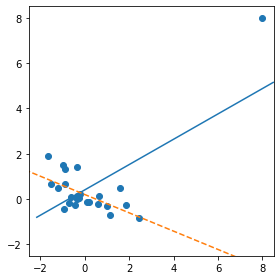

In [78]:
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

print('# 회귀에서 영향력 있는 데이터 포인트의 예')
plt.tight_layout()
plt.show()

- 실선 : 모든 데이터를 고려한 회귀선
- 점선 : 오른쪽 위의 한점을 제거했을 때의 회귀선

# 회귀에서 영향력 있는 데이터 포인트의 예2_쿡의 거리(레버리지+잔차의 크기)


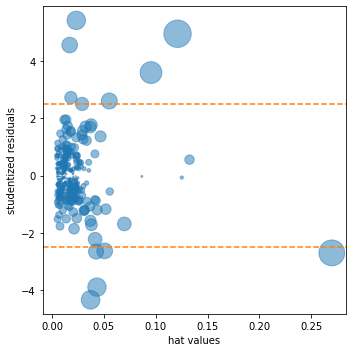

In [80]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

print('# 회귀에서 영향력 있는 데이터 포인트의 예2_쿡의 거리(레버리지+잔차의 크기)')
plt.tight_layout()
plt.show()

- 쿡의 거리가 클수록 점의 크기가 크다.
- 몇몇 점들이 큰 영향력을 보임을 알 수 있다.

In [83]:
print('# 전체 데이터 사용 vs 영향력 값(쿡 0.08이상) 제외 회귀계수 비교')
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

# 전체 데이터 사용 vs 영향력 값(쿡 0.08이상) 제외 회귀계수 비교


,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


##### 3. 이분산성, 비정규성, 오차 간 상관

 - 이분산성(heterokedasticity): 어떤 범위 내 출력값의 잔차가 매우 높은 분산을 보이는 경향(어떤 예측변수를 회귀식이 놓치고 있다는 것을 의미할 수 있다.)

 - 비정규 잔차(non-normal residual): 정규분포를 따르지 않는 잔차는 회귀분석의 요건을 무효로 만들 수 있다. 데이터 과학에서는 별로 중요하게 다뤄지지 않는다.

- 더빈-왓슨 통계량(Durbin-Watson statistic): 시계열 데이터를 다루는 회귀분석에서 유의미한 자기상관(autocorrelation)이 있는지를 탐지하는 데 사용


# 절대잔차와 예측값의 관계 도식화


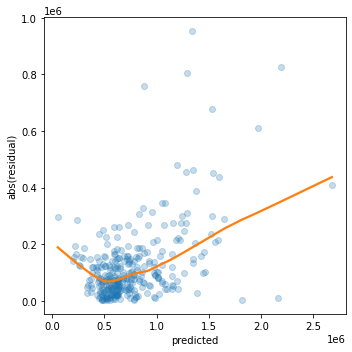

In [85]:
print('# 절대잔차와 예측값의 관계 도식화')
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

- 잔차의 분산이 고가의 주택일 수록 증가하는 경향이 가격이 낮은 주택에서도 보이고 있다. 

 → 이분산성 오차를 갖고 있는 회귀 모델

# 잔차에 대한 히스토그램


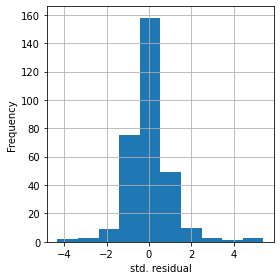

In [86]:
print('# 잔차에 대한 히스토그램')
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- 정규분포보다 더 긴 꼬리를 가지며, 더 큰 잔차에 대한 약간의 왜곡을 보인다.

##### 4. 편잔차그림과 비선형성

- 편잔차그림(partial residual plot): 결과변수와 특정 예측변수 사이의 관계를 진단하는 그림

 편잔차 = 잔차  $ + \hat{b}_i X_i$
 - $\hat{b}_i X_i$ : : 예측 변수($X_i$)와 관련된 회귀항($\hat{b}_i$)

 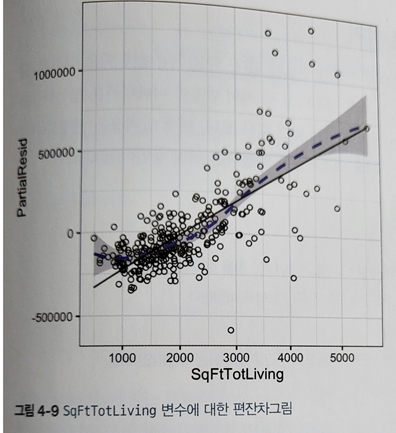


- 점선 : 실제 가격, 실선 : 회귀 선
- 1000제곱피트보다 작은 평수의 집 : 실제 가격보다 낮게 추정
- 2000~3000제곱피트 집 : 실제 가격보다 더 높게 추정
- 4000제곱피트 집 : 데이터 개수가 작아 해석 불가능
- 즉, 원래 큰 집에 500제곱미터를 추가하는 것보다, 작은 집에 500제곱미터를 추가하는게 훨씬 큰 차이를 만든다.

# 7. 다항회귀와 스플라인 회귀

##### 1. 다항식

- 다항회귀(polynomial regression): 회귀모형에 다항식(제곱, 세제곱 등) 항을 추가한 방식

# SqFtTotLiving 2차 다항식 모델
# SqFtTotLiving변수의 다항회귀 결과(진한 선)와 평활곡선(연한 선)


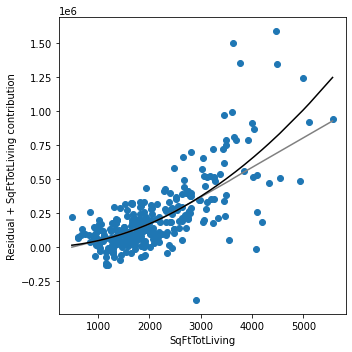

0.038791281682427195


In [103]:
print('# SqFtTotLiving 2차 다항식 모델')
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print('# SqFtTotLiving변수의 다항회귀 결과(진한 선)와 평활곡선(연한 선)')
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

##### 2. 스플라인

- 스플라인 회귀(spline regression): 다항 구간들을 부드러운 곡선 형태로 피팅한다.


스플라인 회귀 결과(진한 선)와 평활곡선(연한 선)


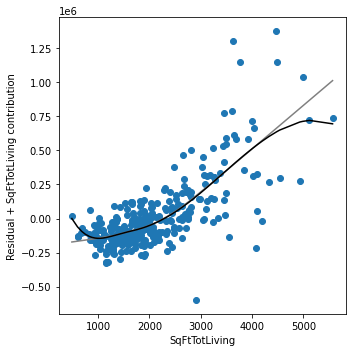

In [123]:
print('스플라인 회귀 결과(진한 선)와 평활곡선(연한 선)')
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

In [124]:
result_spline

- 회귀선이 데이터에 더 가깝게 맞지만, 크기가 아주 작은 주택이 큰 주택보다 더 높은 가치를 가질꺼라는 예측 결과

 → 경제적으로 맞지 않다.(실제랑도 다름)

##### 3. 일반화가법모형(GAM)

- 일반화가법모형=GAM(generalized additive model): 자동으로 구간을 결정하는 스플라인 모델

- 파이썬 코드 s 옵션 : 스플라인 항에 대한 최적 매듭(knot :스플라인 구간을 구분하는 값들)을 찾도록 지시 한다.

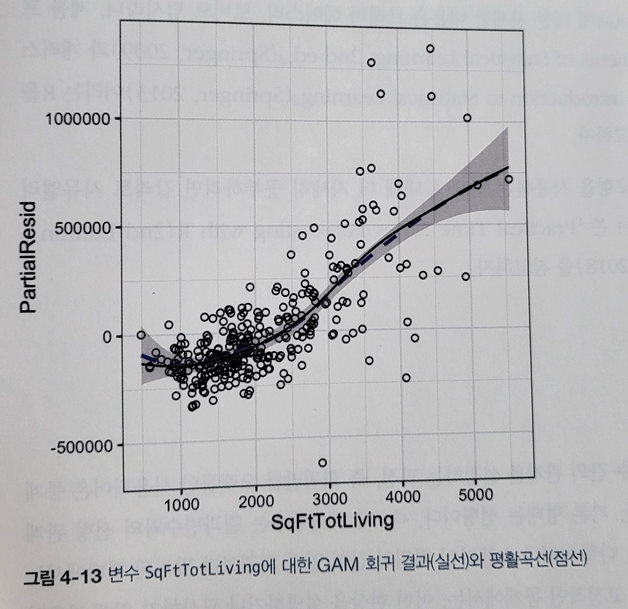

In [125]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
gam.fit(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + l(1) + l(2) + l(3) + l(4) + intercept, tol=0.0001, 
   verbose=False)